## Setting the correct path

In [1]:
import os

model_path = os.path.join(os.getcwd(), 'saved_models')
cifar_working_dir = os.path.dirname(os.path.dirname(model_path))
src_path = os.path.dirname(os.path.dirname(cifar_working_dir))
explanation_path = os.path.join(os.path.dirname(model_path), 'explanation_files')
explanation_heatmap_path = os.path.join(os.path.dirname(model_path), 'explanation_heatmaps')
sanity_checks_output = os.path.join(os.path.join(os.getcwd(), 'sanity_checks'))


print('model_path ', model_path)
print('cifar_working_path ', cifar_working_dir)
print('src_path ', src_path)
print('explanation_path ', explanation_path)
print('explanation_heatmap_path ', explanation_heatmap_path)
print('sanity_checks folder ', sanity_checks_output)

model_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\saved_models
cifar_working_path  D:\Mihir\MT\Code\cifar\GBP_explanation
src_path  D:\Mihir\MT\Code
explanation_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\explanation_files
explanation_heatmap_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\explanation_heatmaps
sanity_checks folder  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\sanity_checks


## Imports

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import re
import time
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import seaborn as sns
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,src_path)

from src.utils import *

np.set_printoptions(suppress=True)

2.8.0
Eager execution enabled : True


## Load data

In [3]:
(x_train, y_train), (x_test, y_test), train_generator, validation_generator, test_generator = load_cifar(num_classes = 10,
val_split = 0.95,
rotation_range = 0.2,
width_shift_range = 0.1, 
height_shift_range = 0.1,
shear_range = 0.1,
zoom_range = 0.1 ,
horizontal_flip = True ,
vertical_flip = False,
rescale = 1/255.,
train_batch_size=1024, 
val_batch_size=1024,
test_batch_size=1024)


# these sets are to be shuffled
#y_train_shuffled = np.argmax(y_train, axis=1)
#y_test_shuffled = np.argmax(y_test, axis=1)

print('original train labels \n ', y_train)
print('original train shape \n ', y_train.shape)
print('original test labels \n ', y_test)
print('original test labels \n ', y_test.shape)

#np.random.shuffle(y_train_shuffled)
#np.random.shuffle(y_test_shuffled)

#print('shuffled train labels \n ', y_train_shuffled)
#print('shuffled train shape \n ', y_train_shuffled.shape)
#print('shuffled test labels \n ', y_test_shuffled)
#print('shuffled test labels \n ', y_test_shuffled.shape)

# convert the shuffled labels to one hot encoding again 
#y_train_shuffled = to_categorical(y_train_shuffled, num_classes=10)
#y_test_shuffled = to_categorical(y_test_shuffled, num_classes=10)

number of examples in train generator  50000
number of examples in val generator  9500
number of examples in test generator  500
original train labels 
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
original train shape 
  (50000, 10)
original test labels 
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
original test labels 
  (10000, 10)


## Class definitions : StochasticModel & StochasticClassifier

In [4]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout

class StochasticDropout(Dropout):
    """
        Applies Dropout to the input, independent of the training phase.
        Used to easily implement MC-Dropout. It is a drop-in replacement for
        the standard Keras Dropout layer, but note that this layer applies
        dropout at the training and inference phases.
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(StochasticDropout, self).__init__(rate, noise_shape, seed, **kwargs)
    
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)

        return inputs

    def get_config(self):
        # this code is added so that the model can be saved even after making use of a custom layer 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        config = super(StochasticDropout, self).get_config()
        config.update({'rate': self.rate})
        return config


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
        

class StochasticClassifier(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output
        self.layers = self.model.layers

    #essentially equivalent to call  
    def __call__(self, inp, num_samples=None, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, **kwargs)
        mean_probs = np.mean(samples, axis=0)
        print('in call function')
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)

        return samples, mean_probs


    def predict_output(self, inp, num_samples=None, batch_size=32, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate sample shape ', samples.shape)
        mean_probs = np.mean(samples, axis=0)
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)
        print('Inside the predict_output() of stochasticclassifier class')

        return samples, mean_probs

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## CIFAR10 class map

In [5]:
cifar_class_map = {0:'airplane',
                   1:'automobile',
                   2:'bird',
                   3:'cat',
                   4:'deer',
                   5:'dog',
                   6:'frog',
                   7:'horse',
                   8:'ship',
                   9:'truck'}

## Load the trained model

In [6]:
# error if the custom object containing the stochastic dropout model not passed (Unknown layer: StochasticDropout. Please ensure this object is passed to the `custom_objects` argument)

import os
test = os.listdir(model_path)
model_checkpoints = []
model_name = []

for item in test:
    if item.endswith('.h5'):
        print('model name : ', item)
        model_name.append(item)
        
print(model_name)
print(sorted(model_name))
best_model_path = model_name[-1]  # model naming template has the third element as epochs, save best will save the highest best performing epoch
print('best model path \n', best_model_path)
trained_model = tf.keras.models.load_model(os.path.join(model_path,item), 
                                   custom_objects={'StochasticDropout':StochasticDropout})

trained_model.summary()

stochastic_model = StochasticClassifier(trained_model, num_samples=10)

model name :  model_epoch_001_loss2.43_tbd.h5
model name :  model_epoch_017_loss2.27_tbd.h5
model name :  model_epoch_018_loss2.14_tbd.h5
model name :  model_epoch_020_loss1.42_tbd.h5
model name :  model_epoch_022_loss1.21_tbd.h5
model name :  model_epoch_023_loss1.11_tbd.h5
model name :  model_epoch_024_loss0.98_tbd.h5
model name :  model_epoch_025_loss0.84_tbd.h5
model name :  model_epoch_026_loss0.80_tbd.h5
model name :  model_epoch_028_loss0.72_tbd.h5
model name :  model_epoch_030_loss0.72_tbd.h5
model name :  model_epoch_033_loss0.69_tbd.h5
model name :  model_epoch_037_loss0.68_tbd.h5
model name :  model_epoch_038_loss0.66_tbd.h5
model name :  model_epoch_040_loss0.64_tbd.h5
model name :  model_epoch_053_loss0.61_tbd.h5
model name :  model_epoch_068_loss0.59_tbd.h5
model name :  model_epoch_078_loss0.57_tbd.h5
model name :  model_epoch_088_loss0.56_tbd.h5
['model_epoch_001_loss2.43_tbd.h5', 'model_epoch_017_loss2.27_tbd.h5', 'model_epoch_018_loss2.14_tbd.h5', 'model_epoch_020_los

## GBP Logic

In [7]:
def guided_bp(test_input, test_label, layer_name, model):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    
    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    
    #print('list of gbp_model layer name : ')
    #for i in gb_model.layers:
    #    print('layer_name_ ', i.name)
    
    #gb_model.summary()
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
    plt.imshow(test_input[0,:,:,:])
    plt.title('Input to be explained \n class : '+
              str(cifar_class_map.get(np.argmax(test_label)))+
              ' ['+str(np.argmax(test_label))+']')
    plt.show()

    with tf.GradientTape() as tape:
        inputs = tf.cast(test_input, tf.float32)
        tape.watch(inputs)

        #outputs = gb_model.predict(inputs) 
        outputs = gb_model(inputs)
        #print('model prediction vector \n', outputs)
        #print('model prediction ', np.argmax(outputs))
        # essentially model() and model.predict() yield the same output with the difference that 
        # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
        #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
        #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()
    
        predicted_class = np.argmax(outputs)
        max_of_predicted_logits = outputs[:, predicted_class]
        desired_class_label = np.argmax(test_label)
        desired_class_logit = outputs[:, desired_class_label]
        print('max of predicted logits : ', max_of_predicted_logits)
        #print('desired class label : ', desired_class_label)
        print('predicted class : ', predicted_class)
        print('GT : ', ground_truth_prediction)
        print('desired class logit : ', desired_class_logit)
        #print('outputs ', outputs)
        #print('inputs \n', inputs)
    
    #print('outputs[:, predicted_class] : ', outputs[:, predicted_class])
    grads = tape.gradient(max_of_predicted_logits, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
    #grads = tape.gradient(desired_class_logit, inputs)[0]
    #print('grads \n', grads)

    #Visualizing the guided back prop
    guided_back_prop = grads
    #print('GBP ', guided_back_prop)
    gb_viz = np.dstack((
                guided_back_prop[:, :, 0],
                guided_back_prop[:, :, 1],
                guided_back_prop[:, :, 2],
            ))      

    #computing magnitude across channels 
    gb_viz = np.sqrt(gb_viz[:, :, 0]**2 + gb_viz[:, :, 1]**2 + gb_viz[:, :, 2]**2)
    #print('gb_viz shape ', gb_viz.shape)
    max_gb_viz = np.max(gb_viz)   # extracting the maximum value of heatmap generated by a individual model comprising the ensemble
    #print('maximum value in unnormalized heatmap number ', i, ' ', np.max(max_gb_viz))   # printing the maximum value before normalizing
    
    normalized_gb_viz = gb_viz / max_gb_viz  # normalizing individual heatmaps as per corresponding maximum value
    #print('maximum value in normalized heatmap number ', i, ' ', np.max(normalized_gb_viz)) 
    
    return normalized_gb_viz, predicted_class, desired_class_logit

## IG Logic

In [8]:
class IntegratedGradient:
    def visualize_input_to_be_explained(self, test_input, test_label):
        # source : https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

        # selecting a sample to explain 
        #test_sample_index=np.random.randint(3000)
        #test_input_temp = x_test[test_sample_index]
        #test_input_temp_norm = test_input_temp/255.0

        #print('image pixel values ', test_input_temp_norm)
        #test_label = y_test[test_sample_index]
        #test_label_string = cifar_class_map.get(np.argmax(test_label))
        #ground_truth = np.argmax(test_label)

        # show the selected sample
        #plt.subplot(121)
        #plt.imshow(test_input)
        #plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
      
        #test_input = tf.expand_dims(test_input_temp, axis=0)

        # plot the baseline
        baseline = np.zeros(shape=(32,32,3))  # shape similar to that of input 

        #plt.subplot(122)
        #plt.imshow(baseline)
        #plt.title("Baseline")
        #plt.axis('off')
        #plt.show()
        return baseline


    def generating_interpolated_images(self, baseline, image, m_steps):
        # generating interpolated images
        m_steps=m_steps
        alphas = np.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.
        alphas_x = alphas[:, np.newaxis, np.newaxis, np.newaxis]

        baseline_x = np.expand_dims(baseline, axis=0)
        baseline_x = np.ndarray.astype(baseline_x, dtype=np.float32)

        input_x = np.expand_dims(image, axis=0)
        input_x = np.ndarray.astype(input_x, dtype=np.float32)

        delta = input_x - baseline_x
        images = baseline_x +  alphas_x * delta
        return alphas, images


    def visualize_interpolated_images(self, alphas, images):
        #convert numpy images to tensor
        #interpolated_images_tensor = tf.convert_to_tensor(interpolated_images)
        fig = plt.figure(figsize=(20, 20))
        i = 0
        print('alphas ', alphas[0::10])
        for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
            i += 1
            plt.subplot(1, len(alphas[0::10]), i)
            plt.title(f'alpha: {alpha:.1f}')
            #image_int = tf.cast(image, tf.int32)
            plt.imshow(image)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    
    def compute_gradients(self, images, ground_truth, stoch_model):
        model = tf.keras.models.Model(inputs=[stoch_model.input],
                                      outputs=[stoch_model.output])    #this step done in order to avoid the 'IteratorGetNext' error 
        #images_adj = tf.squeeze(images, axis=0)  # images have a shape of (1, 51, 32, 32, 3), but model accepts (None, 51, 51, 3) therefore need to squeeze it
        images_adj = tf.convert_to_tensor(images, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(images_adj)
            outputs = model(images_adj)  # this is a (51, 10) vector that contains the predictions for the intermediate images in the form of softmax output
            class_prediction = tf.math.argmax(outputs, axis=1)
            max_output_predictions = tf.math.reduce_max(outputs, axis=1)
            desired_class_logit = outputs[:, np.argmax(ground_truth)]
            #print(desired_class_logit.shape)
            
 
        #probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
        #desired_class_logit = outputs[: ,class_prediction]
        #gradients = tape.gradient(desired_class_logit, images_adj)
        gradients = tape.gradient(max_output_predictions, images_adj)
        #print('gradients shape ', gradients.shape)
        #print('class prediction : ', class_prediction)
        class_prediction_np = list(class_prediction.numpy())   # for the ease of handling the output predictions
        #print('class prediction list : ', class_prediction_np)

        class_prediction_for_a_single_batch = max(set(class_prediction_np), key=class_prediction_np.count)          # https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
        #print('gradients ', gradients)
        #print('gradients shape : ', gradients.shape)
        #return tape.gradient(probs, images)  #original example had shape of (51, 224, 224, 3)
        return class_prediction_for_a_single_batch, gradients, desired_class_logit


    def integral_approximation(self, gradients):
        # riemann_trapezoidal
        grads = (gradients[:-1] + gradients[1:]) / 2.0
        integrated_gradients = np.mean(grads, axis=0)
        return integrated_gradients


    def one_batch(self, baseline, image, ground_truth, alpha_batch, model, m_steps):
        # Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = self.generating_interpolated_images(baseline=baseline,
                                                                            image=image,
                                                                            m_steps=m_steps)[-1]    # since this function returns 4 arguments and here only the 4th is useful
                                                                                                   # this will return (1, 51, 32, 32, 3) 
        # Compute gradients between model outputs and interpolated inputs.
        class_prediction, gradient_batch, desired_class_logit = self.compute_gradients(images=interpolated_path_input_batch, 
                                                                  ground_truth=ground_truth, 
                                                                  stoch_model=model)
                                        
        return class_prediction, gradient_batch, desired_class_logit

    
    def integrated_gradients(self, 
                             baseline,
                             image,
                             ground_truth,
                             m_steps=None,
                             batch_size=None,
                             model=None):
        
        # Generate alphas.
        alphas = np.linspace(start=0.0, stop=1.0, num=m_steps+1)

        # Collect gradients.    
        gradient_batches = []
        prediction_output_for_batches = [] 
        desired_class_logit_batches = []
        

        # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
        for alpha in range(0, len(alphas), batch_size):
            from_ = alpha
            to = np.minimum(from_ + batch_size, len(alphas))
            alpha_batch = alphas[from_:to]
            #print('alpha batches :', alpha_batch)

            #print('image to be explained \n ', image)

            prediction, gradient_batch, desired_class_logit = self.one_batch(baseline, image, ground_truth, alpha_batch, model, m_steps)
            gradient_batches.append(gradient_batch)
            prediction_output_for_batches.append(prediction)
            desired_class_logit_batches.append(np.mean(desired_class_logit))

        # Concatenate path gradients together row-wise into single tensor.
        total_gradients = np.concatenate(gradient_batches, axis=0)
        #print('total gradients shape : ', total_gradients.shape)

        # Integral approximation through averaging gradients.
        avg_gradients = self.integral_approximation(gradients=total_gradients)
        #print('avg gradients shape : ', avg_gradients.shape)

        # Scale integrated gradients with respect to input.
        integrated_gradients = (image - baseline) * avg_gradients

        # identify the majority prediction in individual batch 

        #print('prediction_output_for_batches ', prediction_output_for_batches)

        return prediction_output_for_batches, integrated_gradients, np.mean(desired_class_logit_batches)


    def plot_img_attributions(self, 
                              baseline,
                              image,
                              ground_truth,
                              m_steps=None,
                              model=None):

        prediction_majority_per_batch, attributions, desired_class_logit_value = self.integrated_gradients(baseline=baseline,
                                                 image=image,
                                                 ground_truth=ground_truth,
                                                 batch_size=batch_size,
                                                 m_steps=m_steps,
                                                 model=model)
        
        #print('prediction majority per batch : ', prediction_majority_per_batch)
        prediction_majority_per_batch = [int(i[0]) if i.shape!=() else int(i) for i in prediction_majority_per_batch]
        #print('prediction majority per batch : ', prediction_majority_per_batch)

        
        prediction = max(set(prediction_majority_per_batch), key=prediction_majority_per_batch.count)

        #print('attributions shape : ', attributions.shape)
        #print('baseline shape : ', baseline.shape)
        #attributions = tf.squeeze(attributions, axis=0)
        #baseline = tf.squeeze(baseline, axis=0)


        #print('raw attributions : ', attributions)
        #print('attributions shape : ', attributions.shape)
        #print('baseline shape : ', baseline.shape)
        #print('image shape : ', image.shape)
        #print('prediction_majority_per_batch : ', prediction_majority_per_batch)

        #attributions_np = attributions.numpy()

        attributions_viz = np.dstack((attributions[:, :, 0],
                                      attributions[:, :, 1],   # https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
                                      attributions[:, :, 2],
                    ))      

        #computing magnitude across channels 
        attributions_viz = np.sqrt(attributions_viz[:, :, 0]**2 + attributions_viz[:, :, 1]**2 + attributions_viz[:, :, 2]**2)
        #print('attributions_viz ', attributions_viz)
        #print('attributions_viz shape : ', attributions_viz.shape)

        max_attributions_viz = np.max(attributions_viz)   # extracting the maximum value of heatmap generated by a individual model comprising the ensemble
       
        
        normalized_attributions_viz = attributions_viz / max_attributions_viz  # normalizing individual heatmaps as per corresponding maximum value

        #print('attributions_viz normalized ', normalized_attributions_viz)
        
        #print('maximum value in normalized heatmap number : ', i, ' ', np.max(normalized_attributions_viz)) 

        #print('maximum value in unnormalized heatmap number : ', i, ' ', np.max(attributions_viz))   # printing the maximum value before normalizing
        

        #ORIGINAL CODE 
        # Sum of the attributions across color channels for visualization.
        # The attribution mask shape is a grayscale image with height and width
        # equal to the original image.
        #attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
        #attribution_mask_norm = attribution_mask/tf.math.reduce_max(attribution_mask)
        print('GT : ', np.argmax(ground_truth))
        print('prediction : ', prediction)
        print('desired class logit : ', desired_class_logit_value)
         
        return baseline, image, prediction, attributions_viz, normalized_attributions_viz, desired_class_logit_value

## Pick the image to be visualized

Random index  190
test_input shape : (1, 32, 32, 3)


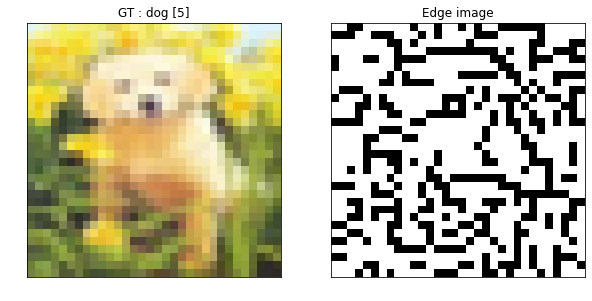

In [9]:
alpha=1
cmap='Greys'
factor=1 # to stabilize the cv heatmap

# Analysis of the test input 
#test_sample_index = np.random.randint(3000)
test_sample_index = 190 #1891
print('Random index ', test_sample_index)
test_input_temp = x_test[test_sample_index]

test_label = y_test[test_sample_index]
test_label_string = cifar_class_map.get(np.argmax(test_label))
ground_truth_prediction = np.argmax(test_label)

test_input = np.expand_dims(test_input_temp, axis=0)
#test_input = test_input/255.0
print('test_input shape :', test_input.shape)

fig = plt.figure(figsize=(10, 5)) 
ax = fig.add_subplot(121)
ax.imshow(test_input_temp)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')

ax = fig.add_subplot(122)
image = (test_input_temp*255).astype(np.uint8)
edge_image = cv2.Canny(image, 200, 200)
ax.imshow(edge_image, cmap='Greys')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('Edge image')

plt.savefig(os.path.join(sanity_checks_output, 
                         'weight_randomization_original_image.png'))
plt.savefig(os.path.join(sanity_checks_output, 
                         'weight_randomization_original_image.pdf'))
plt.show()

## Randomize the network weights [GBP]

xxxxxxxxxxxxxxxxxxxxxxxxxx


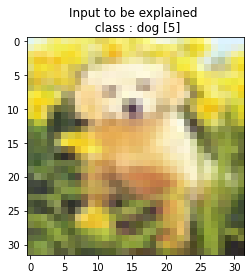

max of predicted logits :  tf.Tensor([0.95883363], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.95883363], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


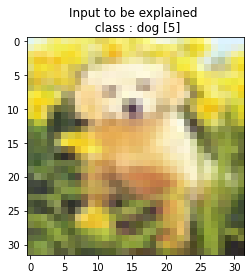

max of predicted logits :  tf.Tensor([0.99898475], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.99898475], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


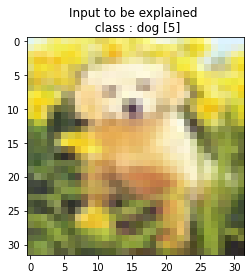

max of predicted logits :  tf.Tensor([0.99480397], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.99480397], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


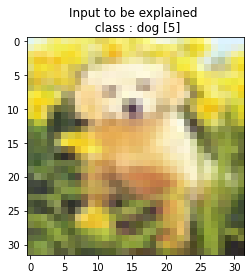

max of predicted logits :  tf.Tensor([0.45845506], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.45845506], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


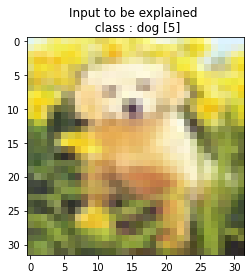

max of predicted logits :  tf.Tensor([0.9895158], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9895158], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


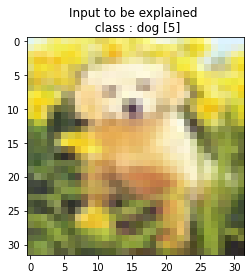

max of predicted logits :  tf.Tensor([0.9838628], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9838628], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


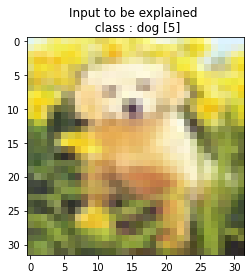

max of predicted logits :  tf.Tensor([0.9860394], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9860394], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


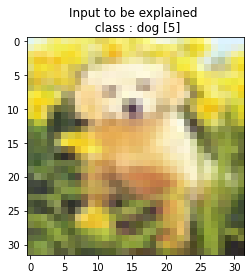

max of predicted logits :  tf.Tensor([0.9507665], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9507665], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


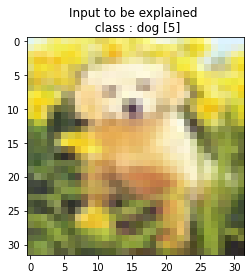

max of predicted logits :  tf.Tensor([0.9043159], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9043159], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxx


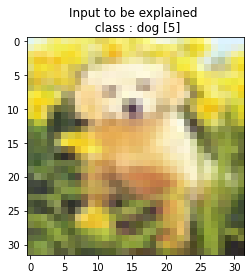

max of predicted logits :  tf.Tensor([0.99673116], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.99673116], shape=(1,), dtype=float32)
layer name :  dense_1
original weight matrix 
 <tf.Variable 'dense_1/kernel:0' shape=(256, 10) dtype=float32, numpy=
array([[-0.0315096 ,  0.03088158,  0.012963  , ..., -0.09141935,
        -0.16565047, -0.05488776],
       [ 0.09168822, -0.04514927,  0.08732098, ..., -0.02419618,
         0.06642801,  0.01330401],
       [-0.07167254, -0.11978265,  0.00517929, ...,  0.15459901,
         0.01042847, -0.08092314],
       ...,
       [-0.10376461, -0.00586525,  0.10587357, ..., -0.04100855,
         0.01318208,  0.04490942],
       [ 0.0851363 , -0.02533528,  0.12839   , ..., -0.05662435,
         0.02857329,  0.16416332],
       [ 0.10597415,  0.09892932, -0.0794505 , ..., -0.1268979 ,
         0.11603174,  0.10631133]], dtype=float32)>
original weight matrix shape  (256, 10)
original bias matrix 
 <tf.Variab

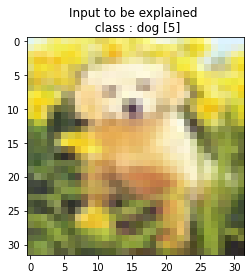

max of predicted logits :  tf.Tensor([0.6521805], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.0350253], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.0350253], shape=(1,), dtype=float32)
Generating explanation_sample #  1
xxxxxxxxxxxxxxxxxxxxxxxxxx


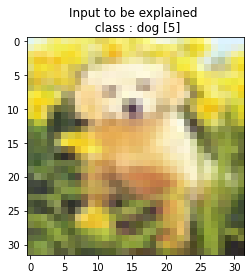

max of predicted logits :  tf.Tensor([0.6391246], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.03437005], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.03437005], shape=(1,), dtype=float32)
Generating explanation_sample #  2
xxxxxxxxxxxxxxxxxxxxxxxxxx


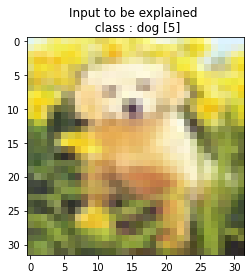

max of predicted logits :  tf.Tensor([0.62969244], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.05778275], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.05778275], shape=(1,), dtype=float32)
Generating explanation_sample #  3
xxxxxxxxxxxxxxxxxxxxxxxxxx


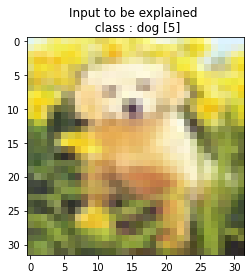

max of predicted logits :  tf.Tensor([0.9512477], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.00074099], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00074099], shape=(1,), dtype=float32)
Generating explanation_sample #  4
xxxxxxxxxxxxxxxxxxxxxxxxxx


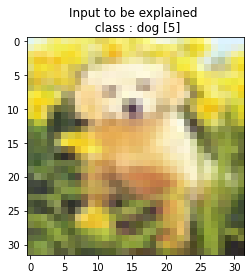

max of predicted logits :  tf.Tensor([0.55743986], shape=(1,), dtype=float32)
predicted class :  4
GT :  5
desired class logit :  tf.Tensor([0.02608428], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.02608428], shape=(1,), dtype=float32)
Generating explanation_sample #  5
xxxxxxxxxxxxxxxxxxxxxxxxxx


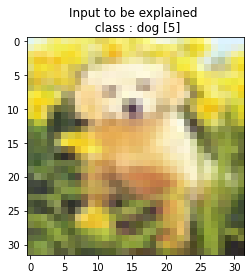

max of predicted logits :  tf.Tensor([0.96132916], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.00196334], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00196334], shape=(1,), dtype=float32)
Generating explanation_sample #  6
xxxxxxxxxxxxxxxxxxxxxxxxxx


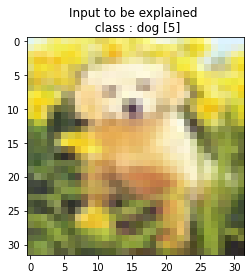

max of predicted logits :  tf.Tensor([0.53112495], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.02193927], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.02193927], shape=(1,), dtype=float32)
Generating explanation_sample #  7
xxxxxxxxxxxxxxxxxxxxxxxxxx


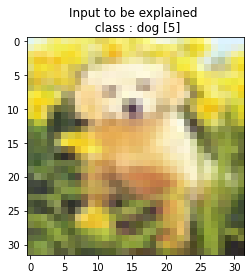

max of predicted logits :  tf.Tensor([0.61998427], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.10543178], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.10543178], shape=(1,), dtype=float32)
Generating explanation_sample #  8
xxxxxxxxxxxxxxxxxxxxxxxxxx


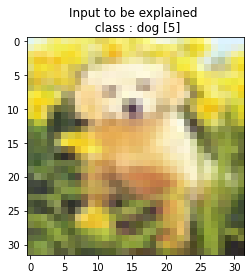

max of predicted logits :  tf.Tensor([0.529398], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.07130711], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.07130711], shape=(1,), dtype=float32)
Generating explanation_sample #  9
xxxxxxxxxxxxxxxxxxxxxxxxxx


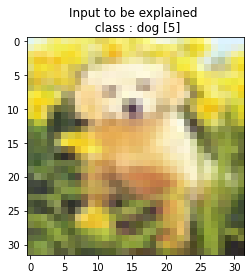

max of predicted logits :  tf.Tensor([0.7065103], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.04443676], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.04443676], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  dense
original weight matrix 
 <tf.Variable 'dense/kernel:0' shape=(2048, 256) dtype=float32, numpy=
array([[ 0.01635516, -0.05168529, -0.11071718, ...,  0.03402766,
         0.00645305,  0.01272642],
       [-0.07816936, -0.02022762, -0.01445041, ...,  0.00853828,
         0.0415067 , -0.03063389],
       [-0.00955508, -0.00635797, -0.08455159, ...,  0.0304511 ,
        -0.00938541, -0.00125565],
       ...,
       [-0.01455613,  0.08242986,  0.07521275, ...,  0.02651634,
        -0.02187886,  0.03605373],
       [-0.04890374,  0.03086115,  0.09199461, ..., -0.05222215,
         0.02174665, -0.01232654],
       [-0.06952179, -0.01842782,  0.00612277, ...,

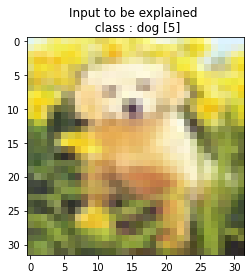

max of predicted logits :  tf.Tensor([0.6251491], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.6251491], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.6251491], shape=(1,), dtype=float32)
Generating explanation_sample #  1
xxxxxxxxxxxxxxxxxxxxxxxxxx


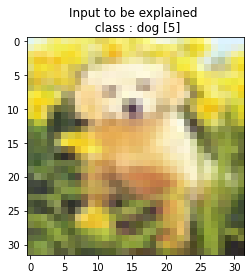

max of predicted logits :  tf.Tensor([0.79508454], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.79508454], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.79508454], shape=(1,), dtype=float32)
Generating explanation_sample #  2
xxxxxxxxxxxxxxxxxxxxxxxxxx


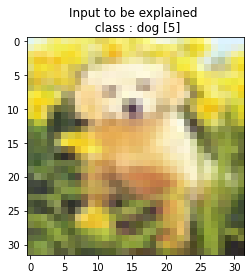

max of predicted logits :  tf.Tensor([0.42180488], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.17356294], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.17356294], shape=(1,), dtype=float32)
Generating explanation_sample #  3
xxxxxxxxxxxxxxxxxxxxxxxxxx


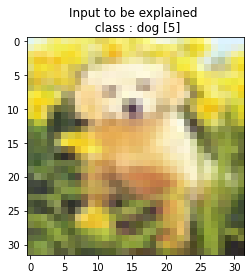

max of predicted logits :  tf.Tensor([0.9709755], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9709755], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.9709755], shape=(1,), dtype=float32)
Generating explanation_sample #  4
xxxxxxxxxxxxxxxxxxxxxxxxxx


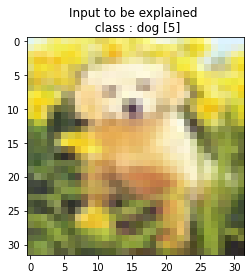

max of predicted logits :  tf.Tensor([0.85429233], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.85429233], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.85429233], shape=(1,), dtype=float32)
Generating explanation_sample #  5
xxxxxxxxxxxxxxxxxxxxxxxxxx


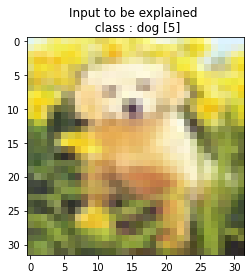

max of predicted logits :  tf.Tensor([0.5143991], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.406609], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.406609], shape=(1,), dtype=float32)
Generating explanation_sample #  6
xxxxxxxxxxxxxxxxxxxxxxxxxx


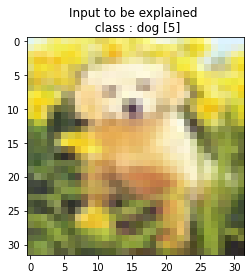

max of predicted logits :  tf.Tensor([0.7714189], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.04481337], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.04481337], shape=(1,), dtype=float32)
Generating explanation_sample #  7
xxxxxxxxxxxxxxxxxxxxxxxxxx


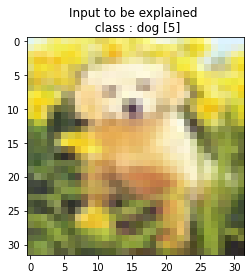

max of predicted logits :  tf.Tensor([0.9554693], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9554693], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.9554693], shape=(1,), dtype=float32)
Generating explanation_sample #  8
xxxxxxxxxxxxxxxxxxxxxxxxxx


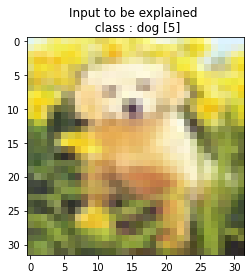

max of predicted logits :  tf.Tensor([0.47375965], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.47375965], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.47375965], shape=(1,), dtype=float32)
Generating explanation_sample #  9
xxxxxxxxxxxxxxxxxxxxxxxxxx


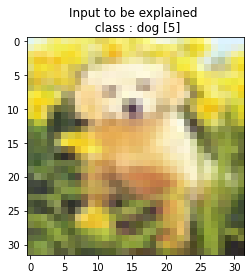

max of predicted logits :  tf.Tensor([0.5952986], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.5952986], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.5952986], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  conv2d_2
original weight matrix 
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 0.06050847,  0.02073958, -0.08033279, ...,  0.00347993,
           0.030426  , -0.00302315],
         [ 0.0258686 , -0.06853254,  0.02411646, ..., -0.00309962,
          -0.01386339, -0.01950177],
         [-0.04888416,  0.015     ,  0.08848884, ..., -0.00522238,
          -0.01578595,  0.06031613],
         ...,
         [ 0.0336546 , -0.11563697,  0.0029361 , ..., -0.0024782 ,
           0.06106176,  0.05039728],
         [-0.03480841, -0.08538634,  0.03498193, ...,  0.01112441,
          -0.04879801, -0.08480646],
         [-0.0069018

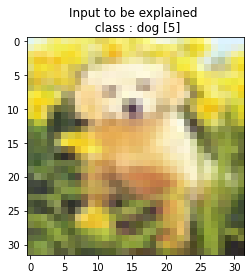

max of predicted logits :  tf.Tensor([0.4711162], shape=(1,), dtype=float32)
predicted class :  4
GT :  5
desired class logit :  tf.Tensor([0.08625976], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.08625976], shape=(1,), dtype=float32)
Generating explanation_sample #  1
xxxxxxxxxxxxxxxxxxxxxxxxxx


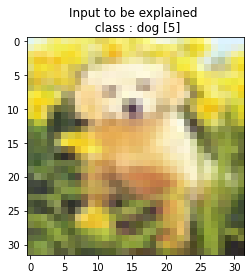

max of predicted logits :  tf.Tensor([0.30446362], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.04015343], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.04015343], shape=(1,), dtype=float32)
Generating explanation_sample #  2
xxxxxxxxxxxxxxxxxxxxxxxxxx


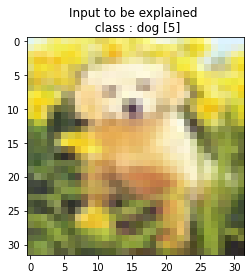

max of predicted logits :  tf.Tensor([0.30714178], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.09277061], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.09277061], shape=(1,), dtype=float32)
Generating explanation_sample #  3
xxxxxxxxxxxxxxxxxxxxxxxxxx


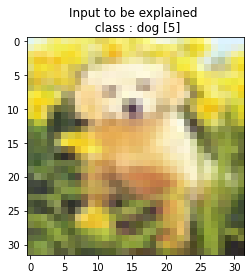

max of predicted logits :  tf.Tensor([0.5348521], shape=(1,), dtype=float32)
predicted class :  6
GT :  5
desired class logit :  tf.Tensor([0.01225015], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.01225015], shape=(1,), dtype=float32)
Generating explanation_sample #  4
xxxxxxxxxxxxxxxxxxxxxxxxxx


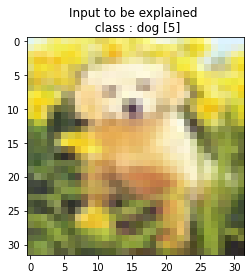

max of predicted logits :  tf.Tensor([0.4188097], shape=(1,), dtype=float32)
predicted class :  1
GT :  5
desired class logit :  tf.Tensor([0.29570398], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.29570398], shape=(1,), dtype=float32)
Generating explanation_sample #  5
xxxxxxxxxxxxxxxxxxxxxxxxxx


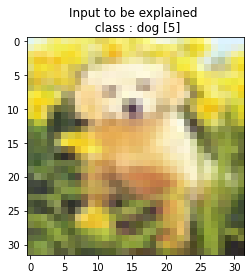

max of predicted logits :  tf.Tensor([0.86208564], shape=(1,), dtype=float32)
predicted class :  6
GT :  5
desired class logit :  tf.Tensor([0.01732215], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.01732215], shape=(1,), dtype=float32)
Generating explanation_sample #  6
xxxxxxxxxxxxxxxxxxxxxxxxxx


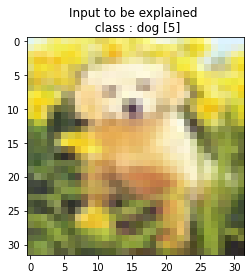

max of predicted logits :  tf.Tensor([0.45098388], shape=(1,), dtype=float32)
predicted class :  6
GT :  5
desired class logit :  tf.Tensor([0.10673179], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.10673179], shape=(1,), dtype=float32)
Generating explanation_sample #  7
xxxxxxxxxxxxxxxxxxxxxxxxxx


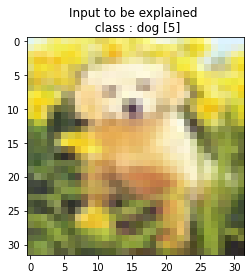

max of predicted logits :  tf.Tensor([0.7197889], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.06281913], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.06281913], shape=(1,), dtype=float32)
Generating explanation_sample #  8
xxxxxxxxxxxxxxxxxxxxxxxxxx


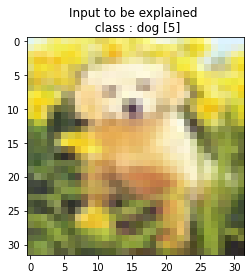

max of predicted logits :  tf.Tensor([0.82261306], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.04019498], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.04019498], shape=(1,), dtype=float32)
Generating explanation_sample #  9
xxxxxxxxxxxxxxxxxxxxxxxxxx


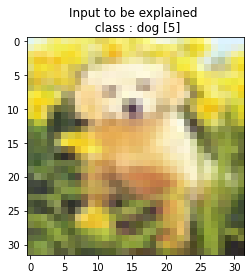

max of predicted logits :  tf.Tensor([0.85413826], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.85413826], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.85413826], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  conv2d_1
original weight matrix 
 <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 64, 128) dtype=float32, numpy=
array([[[[ 0.03431256, -0.0328469 ,  0.06591728, ...,  0.03691322,
           0.00887409, -0.05827321],
         [-0.03243828,  0.02996499,  0.08756047, ...,  0.00914377,
          -0.03015378, -0.05541874],
         [-0.00625992,  0.05571895,  0.02359259, ...,  0.10492761,
           0.08027452,  0.04685438],
         ...,
         [-0.06733772,  0.03243668, -0.03827488, ...,  0.08919027,
          -0.03416421,  0.03094463],
         [-0.04997059, -0.01230574,  0.04256701, ..., -0.06193214,
          -0.04290064,  0.06228671],
         [-0.07467

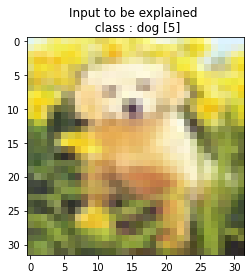

max of predicted logits :  tf.Tensor([0.40722936], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.01220785], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.01220785], shape=(1,), dtype=float32)
Generating explanation_sample #  1
xxxxxxxxxxxxxxxxxxxxxxxxxx


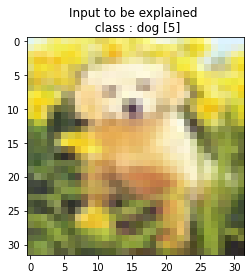

max of predicted logits :  tf.Tensor([0.8072997], shape=(1,), dtype=float32)
predicted class :  1
GT :  5
desired class logit :  tf.Tensor([0.00360085], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00360085], shape=(1,), dtype=float32)
Generating explanation_sample #  2
xxxxxxxxxxxxxxxxxxxxxxxxxx


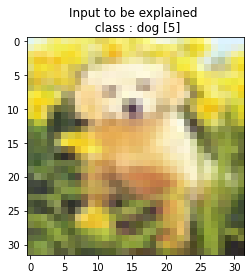

max of predicted logits :  tf.Tensor([0.7239452], shape=(1,), dtype=float32)
predicted class :  1
GT :  5
desired class logit :  tf.Tensor([0.00007113], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00007113], shape=(1,), dtype=float32)
Generating explanation_sample #  3
xxxxxxxxxxxxxxxxxxxxxxxxxx


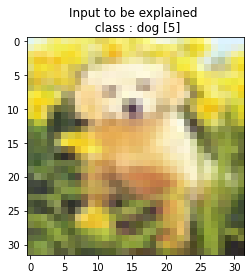

max of predicted logits :  tf.Tensor([0.38330734], shape=(1,), dtype=float32)
predicted class :  1
GT :  5
desired class logit :  tf.Tensor([0.00883647], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00883647], shape=(1,), dtype=float32)
Generating explanation_sample #  4
xxxxxxxxxxxxxxxxxxxxxxxxxx


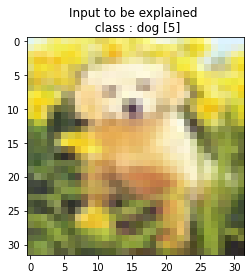

max of predicted logits :  tf.Tensor([0.5954864], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.00005183], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00005183], shape=(1,), dtype=float32)
Generating explanation_sample #  5
xxxxxxxxxxxxxxxxxxxxxxxxxx


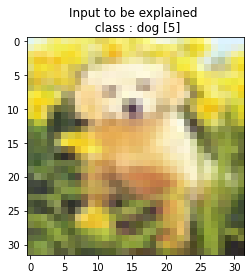

max of predicted logits :  tf.Tensor([0.64382327], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.01632955], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.01632955], shape=(1,), dtype=float32)
Generating explanation_sample #  6
xxxxxxxxxxxxxxxxxxxxxxxxxx


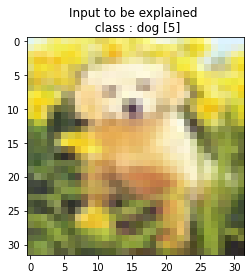

max of predicted logits :  tf.Tensor([0.9126928], shape=(1,), dtype=float32)
predicted class :  7
GT :  5
desired class logit :  tf.Tensor([0.00054321], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00054321], shape=(1,), dtype=float32)
Generating explanation_sample #  7
xxxxxxxxxxxxxxxxxxxxxxxxxx


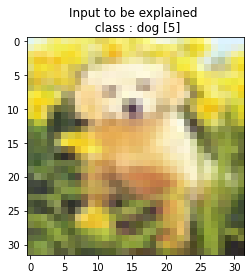

max of predicted logits :  tf.Tensor([0.8955085], shape=(1,), dtype=float32)
predicted class :  1
GT :  5
desired class logit :  tf.Tensor([0.00192769], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00192769], shape=(1,), dtype=float32)
Generating explanation_sample #  8
xxxxxxxxxxxxxxxxxxxxxxxxxx


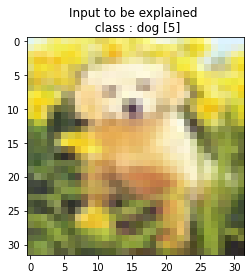

max of predicted logits :  tf.Tensor([0.7894835], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.04762983], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.04762983], shape=(1,), dtype=float32)
Generating explanation_sample #  9
xxxxxxxxxxxxxxxxxxxxxxxxxx


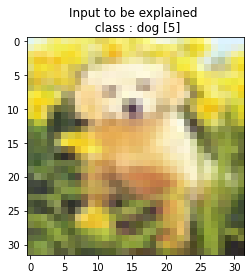

max of predicted logits :  tf.Tensor([0.7866312], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.04809457], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.04809457], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  conv2d
original weight matrix 
 <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 0.01772966,  0.02642991, -0.08229818, ..., -0.0376853 ,
           0.02469675,  0.05421595],
         [-0.00155796, -0.07389223, -0.1339863 , ..., -0.03801554,
           0.0116953 , -0.02502406],
         [ 0.04049473, -0.09352798, -0.09545156, ...,  0.03579963,
           0.06120307, -0.05221492]],

        [[-0.10320015, -0.0622935 , -0.12062698, ..., -0.04444968,
           0.03872319,  0.05876603],
         [ 0.04804526,  0.04832369, -0.00156745, ..., -0.12622829,
          -0.07650125, -0.01471159],
         [-0.08439814,  0.00066031, -

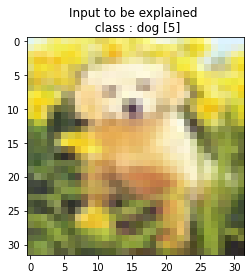

max of predicted logits :  tf.Tensor([0.9188642], shape=(1,), dtype=float32)
predicted class :  4
GT :  5
desired class logit :  tf.Tensor([0.00022832], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00022832], shape=(1,), dtype=float32)
Generating explanation_sample #  1
xxxxxxxxxxxxxxxxxxxxxxxxxx


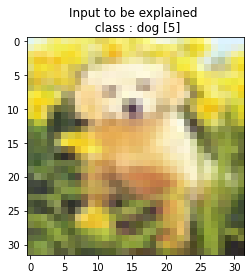

max of predicted logits :  tf.Tensor([0.88628435], shape=(1,), dtype=float32)
predicted class :  7
GT :  5
desired class logit :  tf.Tensor([0.00000005], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00000005], shape=(1,), dtype=float32)
Generating explanation_sample #  2
xxxxxxxxxxxxxxxxxxxxxxxxxx


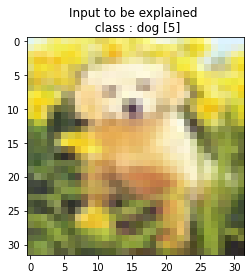

max of predicted logits :  tf.Tensor([0.4134573], shape=(1,), dtype=float32)
predicted class :  3
GT :  5
desired class logit :  tf.Tensor([0.01164281], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.01164281], shape=(1,), dtype=float32)
Generating explanation_sample #  3
xxxxxxxxxxxxxxxxxxxxxxxxxx


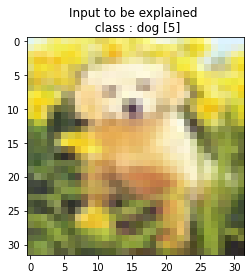

max of predicted logits :  tf.Tensor([0.97283417], shape=(1,), dtype=float32)
predicted class :  8
GT :  5
desired class logit :  tf.Tensor([0.00001081], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00001081], shape=(1,), dtype=float32)
Generating explanation_sample #  4
xxxxxxxxxxxxxxxxxxxxxxxxxx


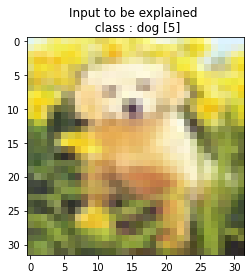

max of predicted logits :  tf.Tensor([0.85230845], shape=(1,), dtype=float32)
predicted class :  4
GT :  5
desired class logit :  tf.Tensor([0.00000003], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00000003], shape=(1,), dtype=float32)
Generating explanation_sample #  5
xxxxxxxxxxxxxxxxxxxxxxxxxx


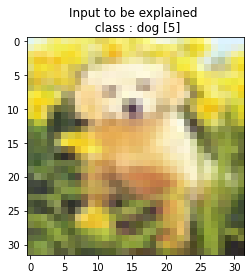

max of predicted logits :  tf.Tensor([0.94944215], shape=(1,), dtype=float32)
predicted class :  7
GT :  5
desired class logit :  tf.Tensor([0.00000007], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00000007], shape=(1,), dtype=float32)
Generating explanation_sample #  6
xxxxxxxxxxxxxxxxxxxxxxxxxx


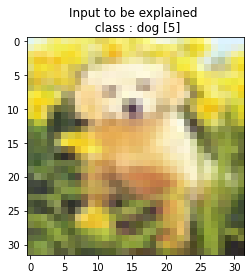

max of predicted logits :  tf.Tensor([0.999527], shape=(1,), dtype=float32)
predicted class :  2
GT :  5
desired class logit :  tf.Tensor([0.00045226], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00045226], shape=(1,), dtype=float32)
Generating explanation_sample #  7
xxxxxxxxxxxxxxxxxxxxxxxxxx


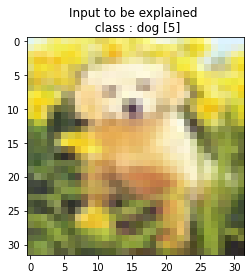

max of predicted logits :  tf.Tensor([0.65671486], shape=(1,), dtype=float32)
predicted class :  6
GT :  5
desired class logit :  tf.Tensor([0.00051555], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.00051555], shape=(1,), dtype=float32)
Generating explanation_sample #  8
xxxxxxxxxxxxxxxxxxxxxxxxxx


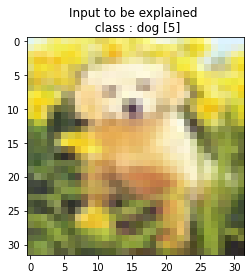

max of predicted logits :  tf.Tensor([0.9979456], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9979456], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.9979456], shape=(1,), dtype=float32)
Generating explanation_sample #  9
xxxxxxxxxxxxxxxxxxxxxxxxxx


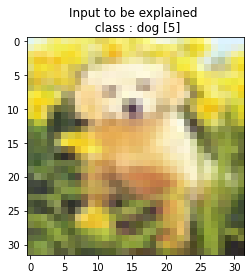

max of predicted logits :  tf.Tensor([0.9476904], shape=(1,), dtype=float32)
predicted class :  5
GT :  5
desired class logit :  tf.Tensor([0.9476904], shape=(1,), dtype=float32)
shape of generated explanation  (32, 32)
desired class logit  tf.Tensor([0.9476904], shape=(1,), dtype=float32)
xxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [10]:
number_of_explanations_single_image = 10 

gbp_explanations_single_image_no_randomization = [] 
gbp_prediction_single_image_no_randomization = [] 
gbp_desired_class_logit_single_image_no_randomization = [] 

list_of_gbp_explanation_for_subsequent_randomizations = [] 
list_of_gbp_prediction_for_subsequent_randomizations = [] 
list_of_gbp_desired_class_logit_for_subsequent_randomizations = []


for i in range(number_of_explanations_single_image):
    gbp_explanation_trained, gbp_prediction_trained, desired_class_logit =  guided_bp(test_input, 
                                                                 test_label,
                                                                 'dense_1',
                                                                 stochastic_model
                                                                )
    gbp_explanations_single_image_no_randomization.append(gbp_explanation_trained)
    gbp_prediction_single_image_no_randomization.append(gbp_prediction_trained)
    gbp_desired_class_logit_single_image_no_randomization.append(desired_class_logit)

list_of_gbp_explanation_for_subsequent_randomizations.append(gbp_explanations_single_image_no_randomization) 
list_of_gbp_prediction_for_subsequent_randomizations.append(gbp_prediction_single_image_no_randomization)
list_of_gbp_desired_class_logit_for_subsequent_randomizations.append(gbp_desired_class_logit_single_image_no_randomization)

# https://stackoverflow.com/questions/47183159/how-to-set-weights-in-keras-with-a-numpy-array
# https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/
for i in reversed(stochastic_model.layers):
    if ('conv' in i.name) or ('dense' in i.name):
        layer_name = i.name
        print('layer name : ', layer_name)
        #extract weight matrix of the layer 
        original_weight_matrix = i.weights[0]
        print('original weight matrix \n', original_weight_matrix)
        print('original weight matrix shape ', original_weight_matrix.shape)

        #extract bias matrix of the layer 
        original_bias_matrix = i.weights[1]
        print('original bias matrix \n', original_bias_matrix)
        print('original bias matrix shape ', original_bias_matrix.shape)

        #print('layer name : ', layer_name)
        randomized_weights_matrix = np.array(tf.keras.initializers.GlorotUniform()(shape=list(original_weight_matrix.shape),dtype=tf.float32))
        print('randomized weight matrix \n', randomized_weights_matrix)
        print('randomized weight matrix shape ', randomized_weights_matrix.shape)

        randomized_bias_matrix = np.zeros(shape=list(original_bias_matrix.shape))
        print('randomized bias matrix \n', randomized_bias_matrix)
        print('randomized bias matrix shape ', randomized_bias_matrix.shape)
        randomized_parameters = [randomized_weights_matrix, randomized_bias_matrix]
        stochastic_model.get_layer(layer_name).set_weights([randomized_weights_matrix, randomized_bias_matrix])

        gbp_explanation_single_image_randomization = [] 
        gbp_prediction_single_image_randomization = [] 
        gbp_desired_class_logit_single_image_randomization = []
        
        for explanation_sample in range(number_of_explanations_single_image):
            print('Generating explanation_sample # ', explanation_sample)
            explanation, prediction, desired_class_logit = guided_bp(test_input, 
                                                test_label,
                                                'dense_1',
                                                stochastic_model
                                                )
            print('shape of generated explanation ', explanation.shape)
            print('desired class logit ', desired_class_logit)
            gbp_explanation_single_image_randomization.append(explanation)
            gbp_prediction_single_image_randomization.append(prediction)
            gbp_desired_class_logit_single_image_randomization.append(desired_class_logit)
        list_of_gbp_explanation_for_subsequent_randomizations.append(gbp_explanation_single_image_randomization) 
        list_of_gbp_prediction_for_subsequent_randomizations.append(gbp_prediction_single_image_randomization)
        list_of_gbp_desired_class_logit_for_subsequent_randomizations.append(gbp_desired_class_logit_single_image_randomization)
        #print('randomized weight matrix ', i)
    
        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxx')

# OLD CODE TO RANDOMIZE THE WEIGHTS LAYERWISE (USES SYMBOLIC EVALUATION HENCE MIGHT BE WRONG)
# INSTEAD USE THE ALTERNATE APPROACH (THAT DOES NOT MAKE USE OF SYMBOLIC EVALUATION)
#for i in model.weights:
#    if 'kernel' in i.name:
#        print(i.name)
#        print('original weight matrix ', i)
#        i.assign(tf.Variable(tf.keras.initializers.GlorotUniform()(shape=list(i.shape),dtype=tf.float32))) #use set_weights instead of assign 
#        explanation, prediction = gbp_explanation(test_input, 
#                                                  test_label,
#                                                  'dense_1',
#                                                  model)
#        gbp_explanation_after_weight_randomization.append(explanation)
#        gbp_prediction_after_weight_randomization.append(prediction)

#        print('randomized weight matrix ', i)
#        print('xxxxxxxxxxxxxxGENERATE EXPLANATIONxxxxxxxxxxxxxx')

## Check to see if the weights are truly randomized or not [GBP]

In [11]:
for i in reversed(stochastic_model.layers):
    layer_name = i.name
    if ('conv' in i.name) or ('dense' in i.name):
        print('layer name ', layer_name)
        print(f'new weight matrix for layer {layer_name} \n', i.weights[0])
        print(f'new bias matrix for layer {layer_name} \n', i.weights[1])
        #original_weights.append(i)
        #i.assign(tf.Variable(tf.keras.initializers.GlorotUniform()(shape=list(i.shape),dtype=tf.float32))) 
        #i = np.array(tf.keras.initializers.GlorotUniform()(shape=list(i.shape),dtype=tf.float32))
        #new_weights.append(i) 
        #print(f'randomized weight matrix for layer {layer_name} \n', i)
        #break
        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxx')

layer name  dense_1
new weight matrix for layer dense_1 
 <tf.Variable 'dense_1/kernel:0' shape=(256, 10) dtype=float32, numpy=
array([[ 0.13766769, -0.14513902, -0.05538823, ..., -0.05013143,
        -0.08683437,  0.03703423],
       [ 0.14613363, -0.11345004, -0.0881301 , ...,  0.06304017,
         0.11376697, -0.00493328],
       [ 0.06146929,  0.04903227,  0.01645935, ...,  0.07771818,
         0.0590525 , -0.08432662],
       ...,
       [-0.11403373,  0.1398479 ,  0.02927351, ..., -0.00314187,
         0.05122864, -0.01843897],
       [-0.04224072, -0.01615497,  0.04999317, ..., -0.1243192 ,
         0.1334453 , -0.01945645],
       [-0.11358456,  0.02474605, -0.04325774, ...,  0.10651216,
        -0.0769498 , -0.02788364]], dtype=float32)>
new bias matrix for layer dense_1 
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name  dense
new weight matrix for layer dense

## Visualize the randomized weights GBP explanation

### No Overlap

list of heatmaps :
 6


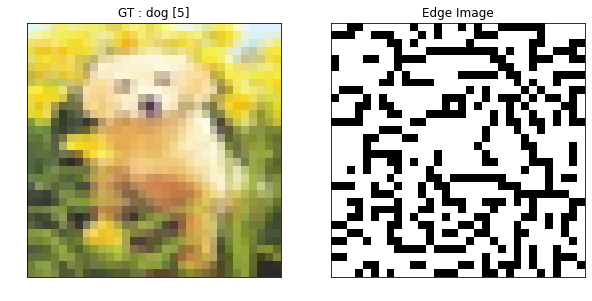

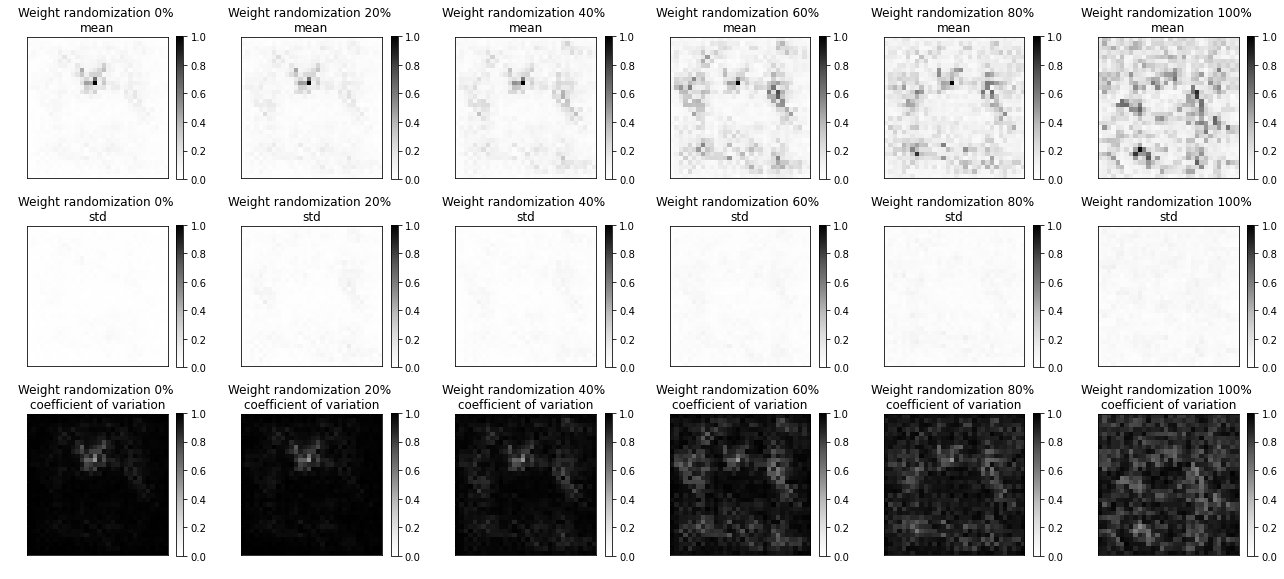

In [12]:
print('list of heatmaps :\n', len(list_of_gbp_prediction_for_subsequent_randomizations))

image = (test_input_temp*255).astype(np.uint8)
edge_image = cv2.Canny(image,200,200)

plt.rcParams['text.color'] = 'black'
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.imshow(test_input_temp)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')

ax = plt.subplot(122)
ax.imshow(edge_image, cmap='Greys')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('Edge Image')
plt.show()

GBP_SSIM_mean = [] 
GBP_SSIM_std = [] 
GBP_desired_class_logit = []

fig = plt.figure(figsize=(18, 8))

fraction = [] 

for i in range(len(list_of_gbp_prediction_for_subsequent_randomizations)):
    fraction_of_layer = int((i/(len(list_of_gbp_prediction_for_subsequent_randomizations)-1))*100)
    fraction.append(fraction_of_layer)
    reference_mean_image = np.mean(np.array(list_of_gbp_explanation_for_subsequent_randomizations[0]), axis=0)
    reference_mean_image_temp = np.expand_dims(reference_mean_image, axis=-1)
    reference_mean_image = np.expand_dims(reference_mean_image_temp, axis=0)

    reference_std_image = np.std(np.array(list_of_gbp_explanation_for_subsequent_randomizations[0]), axis=0)
    reference_std_image_temp = np.expand_dims(reference_std_image, axis=-1)
    reference_std_image = np.expand_dims(reference_std_image_temp, axis=0)
    
    desired_class_logit = np.mean(np.array(list_of_gbp_desired_class_logit_for_subsequent_randomizations[i]), axis=0)

    array_of_gbp_explanation_for_subsequent_randomizations = np.array(list_of_gbp_explanation_for_subsequent_randomizations[i])
    #print(array_of_gbp_explanation_for_subsequent_randomizations.shape)

    mean_individual_image_explanation = np.mean(array_of_gbp_explanation_for_subsequent_randomizations, axis=0)
    #print('mean individual image explanation shape ', mean_individual_image_explanation.shape)

    mean_individual_image_explanation_ssim_temp = np.expand_dims(mean_individual_image_explanation, axis=-1)
    mean_individual_image_explanation_ssim = np.expand_dims(mean_individual_image_explanation_ssim_temp, axis=0)

    std_individual_image_explanation = np.std(array_of_gbp_explanation_for_subsequent_randomizations, axis=0)
    #print('std individual image explanation shape ', std_individual_image_explanation.shape)

    std_individual_image_explanation_ssim_temp = np.expand_dims(std_individual_image_explanation, axis=-1)
    std_individual_image_explanation_ssim = np.expand_dims(std_individual_image_explanation_ssim_temp, axis=0)

    mean_ssim = tf.image.ssim(reference_mean_image, mean_individual_image_explanation_ssim, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    std_ssim = tf.image.ssim(reference_std_image, std_individual_image_explanation_ssim, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)


    GBP_SSIM_mean.append(mean_ssim)
    GBP_SSIM_std.append(std_ssim)
    GBP_desired_class_logit.append(desired_class_logit)

    prediction = max(set(list_of_gbp_prediction_for_subsequent_randomizations[i]), key=list_of_gbp_prediction_for_subsequent_randomizations[i].count)
     
    cv_individual_image_explanation = (std_individual_image_explanation + factor)/(mean_individual_image_explanation + factor)
    
    ax = plt.subplot(3, len(list_of_gbp_prediction_for_subsequent_randomizations), i+1)
    hm = ax.imshow(mean_individual_image_explanation, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('mean heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \nmean')#\n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    ax = plt.subplot(3, len(list_of_gbp_prediction_for_subsequent_randomizations), i+1+len(list_of_gbp_prediction_for_subsequent_randomizations))
    hm = ax.imshow(std_individual_image_explanation, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('std heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \nstd')#\n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    ax = plt.subplot(3, len(list_of_gbp_prediction_for_subsequent_randomizations), i+1+2*len(list_of_gbp_prediction_for_subsequent_randomizations))
    hm = ax.imshow(cv_individual_image_explanation, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('std heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \ncoefficient of variation')#\n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    
    #plt.xlabel()

plt.tight_layout()
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_GBP_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_GBP_new.pdf'), bbox_inches='tight')

#plt.savefig(os.path.join(path, 'output_plots', f'gbp_weight_randomization_{fraction_of_layer}%.png'), bbox_inches='tight')
#plt.savefig(os.path.join(path, 'output_plots', f'gbp_weight_randomization_{fraction_of_layer}%.pdf'), bbox_inches='tight')
plt.show()

### Overlap

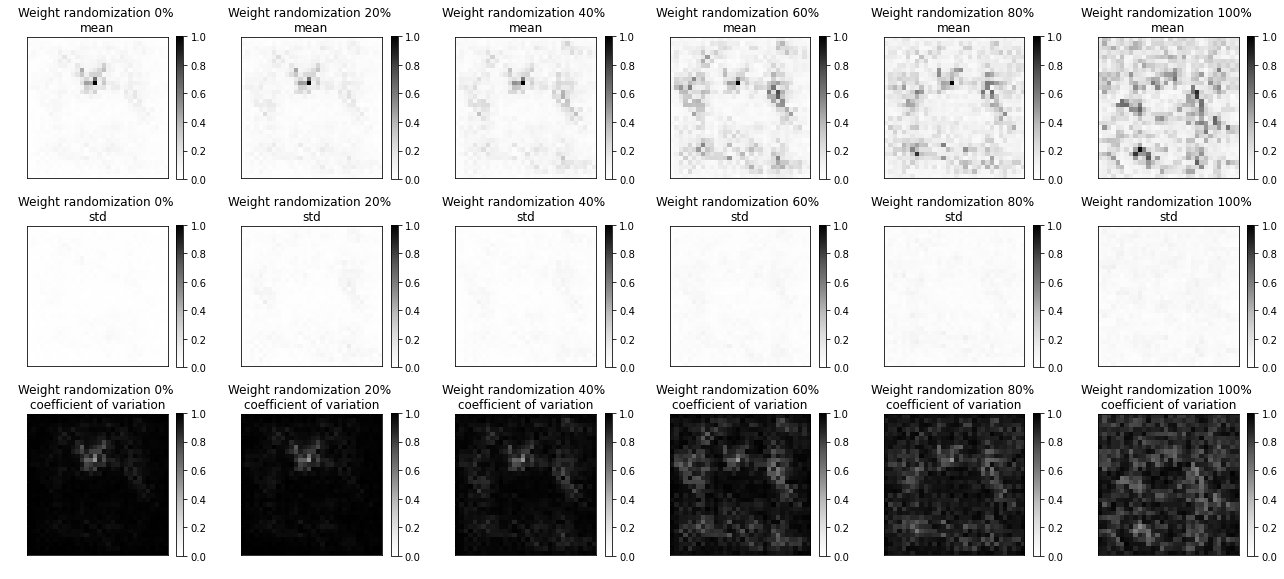

In [13]:
'''
fig = plt.figure(figsize=(18, 8))
for i in range(len(list_of_gbp_prediction_for_subsequent_randomizations)):
    fraction_of_layer = int((i/(len(list_of_gbp_prediction_for_subsequent_randomizations)-1))*100)
    array_of_gbp_explanation_for_subsequent_randomizations = np.array(list_of_gbp_explanation_for_subsequent_randomizations[i])
    #print(array_of_gbp_explanation_for_subsequent_randomizations.shape)

    mean_individual_image_explanation = np.mean(array_of_gbp_explanation_for_subsequent_randomizations, axis=0)
    #print('mean individual image explanation max, min ', np.max(mean_individual_image_explanation), 
                                                        # np.min(mean_individual_image_explanation))

    std_individual_image_explanation = np.std(array_of_gbp_explanation_for_subsequent_randomizations, axis=0)
    #print('std individual image explanation shape ', std_individual_image_explanation.shape)

    prediction = max(set(list_of_gbp_prediction_for_subsequent_randomizations[i]), key=list_of_gbp_prediction_for_subsequent_randomizations[i].count)

    cv_individual_image_explanation = (std_individual_image_explanation + factor)/(mean_individual_image_explanation + factor)
    
    ax = plt.subplot(3, len(list_of_gbp_prediction_for_subsequent_randomizations), i+1)
    ax.imshow(test_input[0])
    hm = plt.imshow(mean_individual_image_explanation, cmap=cmap, alpha=alpha, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    #plt.title('mean heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \nmean')# \n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    ax = plt.subplot(3, len(list_of_gbp_prediction_for_subsequent_randomizations), i+1+len(list_of_gbp_prediction_for_subsequent_randomizations))
    ax.imshow(test_input[0])
    hm = plt.imshow(std_individual_image_explanation, cmap=cmap, alpha=alpha, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    #plt.title('std heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \nstd')# \n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    ax = plt.subplot(3, len(list_of_gbp_prediction_for_subsequent_randomizations), i+1+2*len(list_of_gbp_prediction_for_subsequent_randomizations))
    ax.imshow(test_input[0])
    hm = plt.imshow(cv_individual_image_explanation, cmap=cmap, alpha=alpha, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title(f'Weight randomization {fraction_of_layer}% \ncoefficient of variation')# \n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    
    
plt.tight_layout()
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_GBP_overlap_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_GBP_overlap_new.pdf'), bbox_inches='tight')

#plt.savefig(os.path.join(path, 'output_plots', f'gbp_weight_randomization_{fraction_of_layer}%_overlap.png'), bbox_inches='tight')
#plt.savefig(os.path.join(path, 'output_plots', f'gbp_weight_randomization_{fraction_of_layer}%_overlap.pdf'), bbox_inches='tight')
plt.show()
'''

## Load a fresh copy of model for IG randomization test

In [14]:
# error if the custom object containing the stochastic dropout model not passed (Unknown layer: StochasticDropout. Please ensure this object is passed to the `custom_objects` argument)

import os
test = os.listdir(model_path)
model_checkpoints = []
model_name = []

for item in test:
    if item.endswith('.h5'):
        print('model name : ', item)
        model_name.append(item)
        
print(model_name)
print(sorted(model_name))
best_model_path = model_name[-1]  # model naming template has the third element as epochs, save best will save the highest best performing epoch
print('best model path \n', best_model_path)
trained_model = tf.keras.models.load_model(os.path.join(model_path,item), 
                                   custom_objects={'StochasticDropout':StochasticDropout})

trained_model.summary()

stochastic_model = StochasticClassifier(trained_model, num_samples=10)

model name :  model_epoch_001_loss2.43_tbd.h5
model name :  model_epoch_017_loss2.27_tbd.h5
model name :  model_epoch_018_loss2.14_tbd.h5
model name :  model_epoch_020_loss1.42_tbd.h5
model name :  model_epoch_022_loss1.21_tbd.h5
model name :  model_epoch_023_loss1.11_tbd.h5
model name :  model_epoch_024_loss0.98_tbd.h5
model name :  model_epoch_025_loss0.84_tbd.h5
model name :  model_epoch_026_loss0.80_tbd.h5
model name :  model_epoch_028_loss0.72_tbd.h5
model name :  model_epoch_030_loss0.72_tbd.h5
model name :  model_epoch_033_loss0.69_tbd.h5
model name :  model_epoch_037_loss0.68_tbd.h5
model name :  model_epoch_038_loss0.66_tbd.h5
model name :  model_epoch_040_loss0.64_tbd.h5
model name :  model_epoch_053_loss0.61_tbd.h5
model name :  model_epoch_068_loss0.59_tbd.h5
model name :  model_epoch_078_loss0.57_tbd.h5
model name :  model_epoch_088_loss0.56_tbd.h5
['model_epoch_001_loss2.43_tbd.h5', 'model_epoch_017_loss2.27_tbd.h5', 'model_epoch_018_loss2.14_tbd.h5', 'model_epoch_020_los

## Randomize the network weights [IG]

In [15]:
m_steps=50
batch_size=26 

ig_explainer = IntegratedGradient() 


ig_explanations_single_image_no_randomization = [] 
ig_prediction_single_image_no_randomization = []
ig_desired_class_logit_single_image_no_randomization = []

list_of_ig_explanation_for_subsequent_randomizations = [] 
list_of_ig_prediction_for_subsequent_randomizations = [] 
list_of_ig_desired_class_logit_for_subsequent_randomizations = []


for i in range(number_of_explanations_single_image):
    baseline = ig_explainer.visualize_input_to_be_explained(test_input_temp,
                                                            test_label)
    alphas, interpolated_images = ig_explainer.generating_interpolated_images(baseline=baseline,
                                                                              image=test_input_temp,
                                                                              m_steps=m_steps)

    baseline_im, input_to_be_explained, ig_prediction_trained, ig_explanation_trained, ig_explanation_trained_norm, desired_class_logit = ig_explainer.plot_img_attributions(baseline=baseline,
                                                                                               image=test_input_temp,
                                                                                               ground_truth=test_label,
                                                                                               m_steps=m_steps,
                                                                                               model=stochastic_model)   
    
    ig_explanations_single_image_no_randomization.append(ig_explanation_trained)
    ig_prediction_single_image_no_randomization.append(ig_prediction_trained)
    ig_desired_class_logit_single_image_no_randomization.append(desired_class_logit)
list_of_ig_explanation_for_subsequent_randomizations.append(ig_explanations_single_image_no_randomization) 
list_of_ig_prediction_for_subsequent_randomizations.append(ig_prediction_single_image_no_randomization)
list_of_ig_desired_class_logit_for_subsequent_randomizations.append(ig_desired_class_logit_single_image_no_randomization)

# https://stackoverflow.com/questions/47183159/how-to-set-weights-in-keras-with-a-numpy-array
# https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/
for i in reversed(stochastic_model.layers):
    if ('conv' in i.name) or ('dense' in i.name):
        layer_name = i.name
        print('layer name : ', layer_name)
        #extract weight matrix of the layer 
        original_weight_matrix = i.weights[0]
        print('original weight matrix \n', original_weight_matrix)
        print('original weight matrix shape ', original_weight_matrix.shape)

        #extract bias matrix of the layer 
        original_bias_matrix = i.weights[1]
        print('original bias matrix \n', original_bias_matrix)
        print('original bias matrix shape ', original_bias_matrix.shape)

        #print('layer name : ', layer_name)
        randomized_weights_matrix = np.array(tf.keras.initializers.GlorotUniform()(shape=list(original_weight_matrix.shape),dtype=tf.float32))
        print('randomized weight matrix \n', randomized_weights_matrix)
        print('randomized weight matrix shape ', randomized_weights_matrix.shape)

        randomized_bias_matrix = np.zeros(shape=list(original_bias_matrix.shape))
        print('randomized bias matrix \n', randomized_bias_matrix)
        print('randomized bias matrix shape ', randomized_bias_matrix.shape)
        randomized_parameters = [randomized_weights_matrix, randomized_bias_matrix]
        stochastic_model.get_layer(layer_name).set_weights([randomized_weights_matrix, randomized_bias_matrix])

        ig_explanation_single_image_randomization = [] 
        ig_prediction_single_image_randomization = [] 
        ig_desired_class_logit_single_image_randomization = []
        for explanation_sample in range(number_of_explanations_single_image):
            print('Generating explanation_sample # ', explanation_sample)
            baseline = ig_explainer.visualize_input_to_be_explained(test_input_temp,
                                                                    test_label)
            alphas, interpolated_images = ig_explainer.generating_interpolated_images(baseline=baseline,
                                                                                      image=test_input_temp,
                                                                                      m_steps=m_steps)

            baseline_im, input_to_be_explained, ig_prediction_trained, ig_explanation_trained, ig_explanation_trained_norm, desired_class_logit = ig_explainer.plot_img_attributions(baseline=baseline,
                                                                                               image=test_input_temp,
                                                                                               ground_truth=test_label,
                                                                                               m_steps=m_steps,
                                                                                               model=stochastic_model)   
            ig_explanation_single_image_randomization.append(ig_explanation_trained)
            ig_prediction_single_image_randomization.append(ig_prediction_trained)
            ig_desired_class_logit_single_image_randomization.append(desired_class_logit)
        list_of_ig_explanation_for_subsequent_randomizations.append(ig_explanation_single_image_randomization) 
        list_of_ig_prediction_for_subsequent_randomizations.append(ig_prediction_single_image_randomization)
        list_of_ig_desired_class_logit_for_subsequent_randomizations.append(ig_desired_class_logit_single_image_randomization)
        #print('randomized weight matrix ', i)
    
        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxx')

GT :  5
prediction :  6
desired class logit :  0.32145554
GT :  5
prediction :  6
desired class logit :  0.32886797
GT :  5
prediction :  6
desired class logit :  0.31937313
GT :  5
prediction :  6
desired class logit :  0.27910376
GT :  5
prediction :  6
desired class logit :  0.31305918
GT :  5
prediction :  6
desired class logit :  0.31501174
GT :  5
prediction :  6
desired class logit :  0.3008815
GT :  5
prediction :  6
desired class logit :  0.2870249
GT :  5
prediction :  6
desired class logit :  0.29611123
GT :  5
prediction :  6
desired class logit :  0.2901327
layer name :  dense_1
original weight matrix 
 <tf.Variable 'dense_1/kernel:0' shape=(256, 10) dtype=float32, numpy=
array([[-0.0315096 ,  0.03088158,  0.012963  , ..., -0.09141935,
        -0.16565047, -0.05488776],
       [ 0.09168822, -0.04514927,  0.08732098, ..., -0.02419618,
         0.06642801,  0.01330401],
       [-0.07167254, -0.11978265,  0.00517929, ...,  0.15459901,
         0.01042847, -0.08092314],
      

GT :  5
prediction :  4
desired class logit :  0.0820075
Generating explanation_sample #  4
GT :  5
prediction :  4
desired class logit :  0.06969184
Generating explanation_sample #  5
GT :  5
prediction :  4
desired class logit :  0.06784859
Generating explanation_sample #  6
GT :  5
prediction :  4
desired class logit :  0.06729764
Generating explanation_sample #  7
GT :  5
prediction :  4
desired class logit :  0.06218613
Generating explanation_sample #  8
GT :  5
prediction :  4
desired class logit :  0.0887265
Generating explanation_sample #  9
GT :  5
prediction :  0
desired class logit :  0.08113605
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  conv2d_2
original weight matrix 
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 0.06050847,  0.02073958, -0.08033279, ...,  0.00347993,
           0.030426  , -0.00302315],
         [ 0.0258686 , -0.06853254,  0.02411646, ..., -0.00309962,
          -0.01386339, -0.01950177],
         [-0.04888416, 

GT :  5
prediction :  2
desired class logit :  0.025488574
Generating explanation_sample #  1
GT :  5
prediction :  2
desired class logit :  0.032118805
Generating explanation_sample #  2
GT :  5
prediction :  2
desired class logit :  0.03147528
Generating explanation_sample #  3
GT :  5
prediction :  2
desired class logit :  0.029366221
Generating explanation_sample #  4
GT :  5
prediction :  2
desired class logit :  0.025683852
Generating explanation_sample #  5
GT :  5
prediction :  0
desired class logit :  0.025834339
Generating explanation_sample #  6
GT :  5
prediction :  0
desired class logit :  0.0341629
Generating explanation_sample #  7
GT :  5
prediction :  2
desired class logit :  0.02962259
Generating explanation_sample #  8
GT :  5
prediction :  2
desired class logit :  0.0314769
Generating explanation_sample #  9
GT :  5
prediction :  0
desired class logit :  0.032123595
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  conv2d_1
original weight matrix 
 <tf.Variable 'conv2d_1/k

GT :  5
prediction :  2
desired class logit :  0.0801913
Generating explanation_sample #  7
GT :  5
prediction :  2
desired class logit :  0.07935402
Generating explanation_sample #  8
GT :  5
prediction :  9
desired class logit :  0.085817605
Generating explanation_sample #  9
GT :  5
prediction :  9
desired class logit :  0.07570482
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name :  conv2d
original weight matrix 
 <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[ 0.01772966,  0.02642991, -0.08229818, ..., -0.0376853 ,
           0.02469675,  0.05421595],
         [-0.00155796, -0.07389223, -0.1339863 , ..., -0.03801554,
           0.0116953 , -0.02502406],
         [ 0.04049473, -0.09352798, -0.09545156, ...,  0.03579963,
           0.06120307, -0.05221492]],

        [[-0.10320015, -0.0622935 , -0.12062698, ..., -0.04444968,
           0.03872319,  0.05876603],
         [ 0.04804526,  0.04832369, -0.00156745, ..., -0.12622829,
          -0.07650125, -0.0147

## Check to see if the weights are truly randomized or not [IG]

In [16]:
for i in reversed(stochastic_model.layers):
    layer_name = i.name
    if ('conv' in i.name) or ('dense' in i.name):
        print('layer name ', layer_name)
        print(f'new weight matrix for layer {layer_name} \n', i.weights[0])
        print(f'new bias matrix for layer {layer_name} \n', i.weights[1])
        #original_weights.append(i)
        #i.assign(tf.Variable(tf.keras.initializers.GlorotUniform()(shape=list(i.shape),dtype=tf.float32))) 
        #i = np.array(tf.keras.initializers.GlorotUniform()(shape=list(i.shape),dtype=tf.float32))
        #new_weights.append(i) 
        #print(f'randomized weight matrix for layer {layer_name} \n', i)
        #break
        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxx')

layer name  dense_1
new weight matrix for layer dense_1 
 <tf.Variable 'dense_1/kernel:0' shape=(256, 10) dtype=float32, numpy=
array([[-0.04287674, -0.0524248 ,  0.12020051, ...,  0.04375979,
         0.08688629,  0.12272254],
       [ 0.1350275 ,  0.09941983, -0.0417937 , ..., -0.07004599,
        -0.07092199,  0.02753384],
       [ 0.08412771,  0.11992833,  0.1374281 , ...,  0.0282183 ,
         0.03540237, -0.03771658],
       ...,
       [-0.06375707,  0.01424114, -0.0633306 , ...,  0.11154211,
        -0.0189257 , -0.09956951],
       [-0.02269877,  0.11582908,  0.1009064 , ..., -0.06933238,
        -0.00932598, -0.02183546],
       [-0.12057362,  0.03475501, -0.01935765, ..., -0.1225294 ,
         0.10830301, -0.1054533 ]], dtype=float32)>
new bias matrix for layer dense_1 
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
layer name  dense
new weight matrix for layer dense

## Visualize the randomized weights IG explanation

### No Overlap

list of heatmaps :
 6
list of heatmaps :
 6


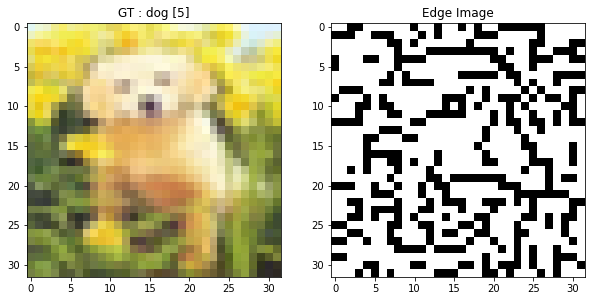

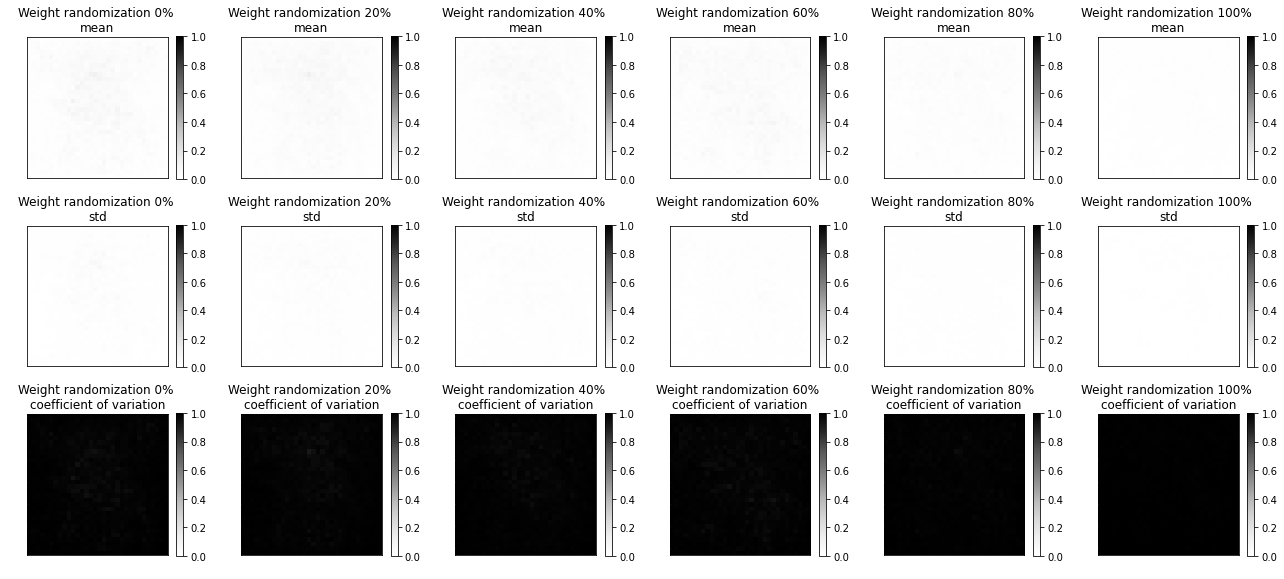

In [17]:
print('list of heatmaps :\n', len(list_of_ig_prediction_for_subsequent_randomizations))
print('list of heatmaps :\n', len(list_of_ig_desired_class_logit_for_subsequent_randomizations))

image = (test_input_temp*255).astype(np.uint8)
edge_image = cv2.Canny(image,200,200)

plt.rcParams['text.color'] = 'black'
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(test_input_temp)
plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')

plt.subplot(122)
plt.imshow(edge_image, cmap='Greys')
plt.title('Edge Image')
plt.show()

IG_SSIM_mean = [] 
IG_SSIM_std = [] 
IG_desired_class_logit = []


fig = plt.figure(figsize=(18, 8))

for i in range(len(list_of_ig_prediction_for_subsequent_randomizations)):
    fraction_of_layer = int((i/(len(list_of_ig_prediction_for_subsequent_randomizations)-1))*100)
    reference_mean_image = np.mean(np.array(list_of_ig_explanation_for_subsequent_randomizations[0]), axis=0)
    reference_mean_image_temp = np.expand_dims(reference_mean_image, axis=-1)
    reference_mean_image = np.expand_dims(reference_mean_image_temp, axis=0)

    reference_std_image = np.std(np.array(list_of_ig_explanation_for_subsequent_randomizations[0]), axis=0)
    reference_std_image_temp = np.expand_dims(reference_std_image, axis=-1)
    reference_std_image = np.expand_dims(reference_std_image_temp, axis=0)

    desired_class_logit = np.mean(np.array(list_of_ig_desired_class_logit_for_subsequent_randomizations[i]), axis=0)
    
    array_of_ig_explanation_for_subsequent_randomizations = np.array(list_of_ig_explanation_for_subsequent_randomizations[i])
    #print(array_of_ig_explanation_for_subsequent_randomizations.shape)

    mean_individual_image_explanation = np.mean(array_of_ig_explanation_for_subsequent_randomizations, axis=0)
    
    mean_individual_image_explanation_ssim_temp = np.expand_dims(mean_individual_image_explanation, axis=-1)
    mean_individual_image_explanation_ssim = np.expand_dims(mean_individual_image_explanation_ssim_temp, axis=0)

    std_individual_image_explanation = np.std(array_of_ig_explanation_for_subsequent_randomizations, axis=0)
    #print('std individual image explanation shape ', std_individual_image_explanation.shape)

    std_individual_image_explanation_ssim_temp = np.expand_dims(std_individual_image_explanation, axis=-1)
    std_individual_image_explanation_ssim = np.expand_dims(std_individual_image_explanation_ssim_temp, axis=0)
          
    mean_ssim = tf.image.ssim(reference_mean_image, mean_individual_image_explanation_ssim, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    std_ssim = tf.image.ssim(reference_std_image, std_individual_image_explanation_ssim, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)

    IG_SSIM_mean.append(mean_ssim)
    IG_SSIM_std.append(std_ssim)
    IG_desired_class_logit.append(desired_class_logit)

    prediction = max(set(list_of_ig_prediction_for_subsequent_randomizations[i]), key=list_of_ig_prediction_for_subsequent_randomizations[i].count)
    cv_individual_image_explanation = (std_individual_image_explanation + factor)/(mean_individual_image_explanation + factor)

    ax = plt.subplot(3, len(list_of_ig_prediction_for_subsequent_randomizations), i+1)
    hm = ax.imshow(mean_individual_image_explanation, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('mean heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \nmean')# \n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    
    ax = plt.subplot(3, len(list_of_ig_prediction_for_subsequent_randomizations), i+1+len(list_of_ig_prediction_for_subsequent_randomizations))
    hm = ax.imshow(std_individual_image_explanation, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('std heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \nstd')# \n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    ax = plt.subplot(3, len(list_of_ig_prediction_for_subsequent_randomizations), i+1+2*len(list_of_ig_prediction_for_subsequent_randomizations))
    hm = ax.imshow(cv_individual_image_explanation, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('std heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    #plt.title(f'Weight randomization {fraction_of_layer}% \ncoefficient of variation')# \n'+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    
    
    #plt.xlabel(f'Weight randomization {fraction_of_layer}% ')
    


plt.tight_layout()
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_IG_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_IG_new.pdf'), bbox_inches='tight')

#plt.savefig(os.path.join(path, 'output_plots', f'ig_weight_randomization_{fraction_of_layer}%.png'), bbox_inches='tight')
#plt.savefig(os.path.join(path, 'output_plots', f'ig_weight_randomization_{fraction_of_layer}%.pdf'), bbox_inches='tight')
plt.show()

### Overlap

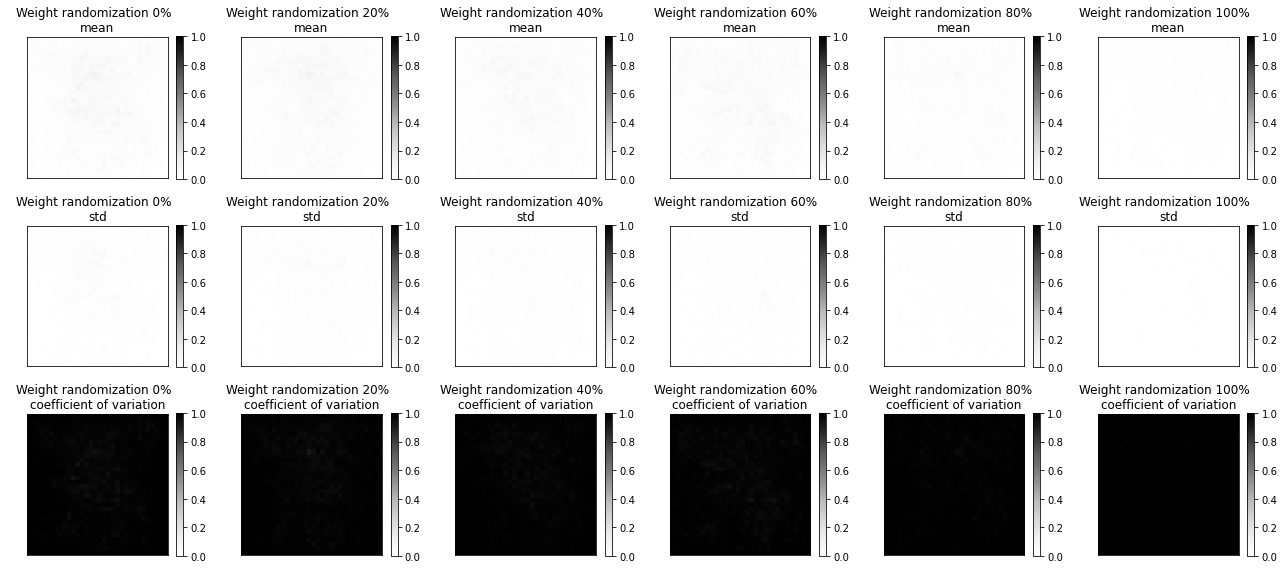

In [18]:
'''
fig = plt.figure(figsize=(18, 8))
for i in range(len(list_of_ig_prediction_for_subsequent_randomizations)):
    fraction_of_layer = int((i/(len(list_of_ig_prediction_for_subsequent_randomizations)-1))*100)
    
    array_of_ig_explanation_for_subsequent_randomizations = np.array(list_of_ig_explanation_for_subsequent_randomizations[i])
    #print(array_of_ig_explanation_for_subsequent_randomizations.shape)

    mean_individual_image_explanation = np.mean(array_of_ig_explanation_for_subsequent_randomizations, axis=0)
    #print('mean individual image explanation shape ', mean_individual_image_explanation.shape)

    std_individual_image_explanation = np.std(array_of_ig_explanation_for_subsequent_randomizations, axis=0)
    #print('std individual image explanation shape ', std_individual_image_explanation.shape)

    max(set(list_of_ig_prediction_for_subsequent_randomizations[i]), key=list_of_ig_prediction_for_subsequent_randomizations[i].count)

    ax = plt.subplot(3, len(list_of_ig_prediction_for_subsequent_randomizations), i+1)
    plt.imshow(test_input[0])
    hm = ax.imshow(mean_individual_image_explanation, cmap=cmap, alpha=alpha, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('mean heatmap \n Pred : '+ cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    plt.title(f'Weight randomization {fraction_of_layer}%  \nmean')
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+'['+str(np.argmax(test_label))+']')
    
    ax = plt.subplot(3, len(list_of_ig_prediction_for_subsequent_randomizations), i+1+len(list_of_ig_prediction_for_subsequent_randomizations))
    plt.imshow(test_input[0])
    hm = ax.imshow(std_individual_image_explanation, cmap=cmap, alpha=alpha, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('std heatmap \n Pred : '+ 
    #          cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    plt.title(f'Weight randomization {fraction_of_layer}%  \nstd')
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+'['+str(np.argmax(test_label))+']')
    
    cv_individual_image_explanation = (std_individual_image_explanation + factor) / (mean_individual_image_explanation + factor)
    ax = plt.subplot(3, len(list_of_ig_prediction_for_subsequent_randomizations), i+1+2*len(list_of_ig_prediction_for_subsequent_randomizations))
    plt.imshow(test_input[0])
    hm = ax.imshow(cv_individual_image_explanation, cmap=cmap, alpha=alpha, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    #plt.title('std heatmap \n Pred : '+ 
    #          cifar_class_map.get(prediction)+
    #          ' ['+str(prediction)+']'+
    #          '\nGT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
    plt.title(f'Weight randomization {fraction_of_layer}%  \ncoefficient of variation')#+
              #'GT : '+cifar_class_map.get(np.argmax(test_label))+'['+str(np.argmax(test_label))+']')
    
    
    

      
plt.tight_layout()
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_IG_overlap_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_{fraction_of_layer}%_IG_overlap_new.pdf'), bbox_inches='tight')
#plt.savefig(os.path.join(path, 'output_plots', f'ig_weight_randomization_{fraction_of_layer}%_overlap.png'), bbox_inches='tight')
#plt.savefig(os.path.join(path, 'output_plots', f'ig_weight_randomization_{fraction_of_layer}%_overlap.pdf'), bbox_inches='tight')
plt.show()
'''

## Comparing SSIM

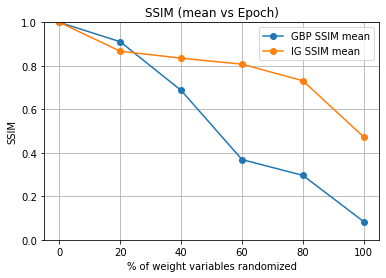

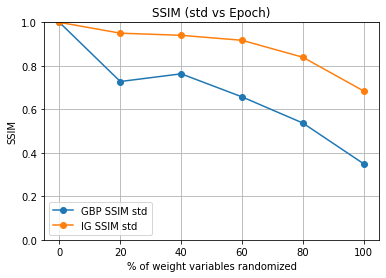

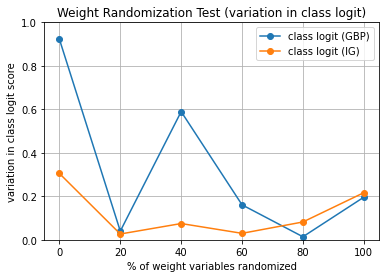

In [19]:
plt.plot(fraction, GBP_SSIM_mean, 'o-',  label='GBP SSIM mean')
plt.plot(fraction, IG_SSIM_mean, 'o-', label='IG SSIM mean')
plt.xlabel('% of weight variables randomized')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.grid()
plt.title(f'SSIM (mean vs Epoch)')
plt.legend()

plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_mean_SSIM_comparison_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_mean_SSIM_comparison_new.pdf'), bbox_inches='tight')
plt.show()


plt.plot(fraction, GBP_SSIM_std, 'o-', label='GBP SSIM std')
plt.plot(fraction, IG_SSIM_std, 'o-',  label='IG SSIM std')
plt.xlabel('% of weight variables randomized')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.grid()
plt.title(f'SSIM (std vs Epoch)')
plt.legend()

plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_std_SSIM_comparison_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_std_SSIM_comparison_new.pdf'), bbox_inches='tight')
plt.show()


plt.plot(fraction, GBP_desired_class_logit, 'o-', label='class logit (GBP)')
plt.plot(fraction, IG_desired_class_logit, 'o-',  label='class logit (IG)')
plt.xlabel('% of weight variables randomized')
plt.ylabel('variation in class logit score')
plt.ylim(0, 1)
plt.grid()
plt.title(f'Weight Randomization Test (variation in class logit)')
plt.legend()

plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_class_logit_variation_new.png'), bbox_inches='tight')
plt.savefig(os.path.join(sanity_checks_output, f'weight_randomization_class_logit_variation_new.pdf'), bbox_inches='tight')
plt.show()
#plt.savefig(os.path.join(path, 'output_plots', f'SSIM_comparison.pdf'), bbox_inches='tight')
#plt.savefig(os.path.join(path, 'output_plots', f'SSIM_comparison.png'), bbox_inches='tight')

#saving the ssim lists in a txt file
#np.save(os.path.join(path, 'SSIM_readings',
#                     f'gbp_ssim_{test_sample_index}.npy'), 
#                     GBP_SSIM, 
#                     allow_pickle=True)

#np.save(os.path.join(path, 'SSIM_readings',
#                     f'ig_ssim_{test_sample_index}.npy'), 
#                     IG_SSIM, 
#                     allow_pickle=True)